# Task 3

# Importing packages

In [2]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers
import shutil
import random
from PIL import Image
import numpy as np
import logging
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn import svm
from sklearn import datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.python.client import device_lib
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers
import tensorflow_hub as hub
import shutil
import random
from PIL import Image
import pickle
import shutil
import matplotlib

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
print(tf.__version__)

2.8.0


# Resizing the images

In [15]:
# load every image in the food folder and resize them to 224x224, then save them in a new folder
IMG_SHAPE = 224
for filename in os.listdir('food'):
    img = Image.open('food/' + filename)
    img = img.resize((IMG_SHAPE, IMG_SHAPE))
    img.save('food_'+str(IMG_SHAPE)+'/' + filename)


# setting up the triplets

In [3]:
line_id = 0
with open('train_triplets.txt', 'r') as f:
    # go through the lines
    for line in f:
        line = line.replace("\n", "")

        shutil.copy("food_224/" + line.split(' ')[0] + ".jpg","triplets/anchor/class1/" + str(line_id) + ".jpg")
        # line_id += 1
        shutil.copy("food_224/" + line.split(' ')[1] + ".jpg","triplets/positive/class1/" + str(line_id) + ".jpg")
        # line_id += 1
        shutil.copy("food_224/" + line.split(' ')[2] + ".jpg","triplets/negative/class1/" + str(line_id) + ".jpg")
        line_id += 1

        if line_id % 1000 == 0:
            print(line_id)
            # break

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000


### This section was an attempt at caching the augmented images to improve runtime. the code works, but the score is slightly worse when using this

In [3]:
batch_size = 1
#,save_to_dir="./aug_triplets/anchor/",save_format='jpg',save_prefix='aug_'

# gen1 = ImageDataGenerator(rescale=1./255)
# gen1 = gen1.flow_from_directory(batch_size=batch_size,directory="./triplets/anchor/",shuffle=False,target_size=(224,224),class_mode=None)
# gen2 = ImageDataGenerator(rescale=1./255)
# gen2 = gen2.flow_from_directory(batch_size=batch_size,directory="./triplets/positive/",shuffle=False,target_size=(224,224),class_mode=None)
# gen3 = ImageDataGenerator(rescale=1./255)
# gen3 = gen3.flow_from_directory(batch_size=batch_size,directory="./triplets/negative/",shuffle=False,target_size=(224,224),class_mode=None)


# gen1 = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
# gen1 = gen1.flow_from_directory(batch_size=batch_size,directory="./triplets/anchor/",shuffle=False,target_size=(224,224),class_mode=None)
# gen2 = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
# gen2 = gen2.flow_from_directory(batch_size=batch_size,directory="./triplets/positive/",shuffle=False,target_size=(224,224),class_mode=None)
# gen3 = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
# gen3 = gen3.flow_from_directory(batch_size=batch_size,directory="./triplets/negative/",shuffle=False,target_size=(224,224),class_mode=None)

gen1 = ImageDataGenerator(rescale=1./255,horizontal_flip=True,rotation_range=15,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.1,shear_range=0.1,fill_mode='nearest')
gen1 = gen1.flow_from_directory(batch_size=batch_size,directory="./triplets/anchor/",shuffle=False,target_size=(224,224),class_mode=None)
gen2 = ImageDataGenerator(rescale=1./255,horizontal_flip=True,rotation_range=15,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.1,shear_range=0.1,fill_mode='nearest')
gen2 = gen2.flow_from_directory(batch_size=batch_size,directory="./triplets/positive/",shuffle=False,target_size=(224,224),class_mode=None)
gen3 = ImageDataGenerator(rescale=1./255,horizontal_flip=True,rotation_range=15,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.1,shear_range=0.1,fill_mode='nearest')
gen3 = gen3.flow_from_directory(batch_size=batch_size,directory="./triplets/negative/",shuffle=False,target_size=(224,224),class_mode=None)


class JoinedGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen1, input_gen2, target_gen):
        self.gen1 = input_gen1
        self.gen2 = input_gen2
        self.gen3 = target_gen

        assert len(input_gen1) == len(input_gen2) == len(target_gen)

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, i):
        x1 = self.gen1[i]
        x2 = self.gen2[i]
        x3 = self.gen3[i]

        # x1 = tf.convert_to_tensor(x1)
        # x2 = tf.convert_to_tensor(x2)
        # x3 = tf.convert_to_tensor(x3)

        # return (np.random.rand(224,224,3), np.random.rand(224,224,3), np.random.rand(224,224,3))
        # return [x1, x2, x3], np.random.rand(1,224,224,3)
        # return ([x1, x2, x3],x3)
        return [x1, x2, x3]
        # return (x1, x2, x3)
        # return (x1.copy(), x2.copy(), x3.copy())
        # return x1, x2, x3

    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()
        self.gen3.on_epoch_end()

my_gen = JoinedGen(gen1, gen2, gen3)


Found 59520 images belonging to 1 classes.
Found 59520 images belonging to 1 classes.
Found 59520 images belonging to 1 classes.


(3, 1, 224, 224, 3)


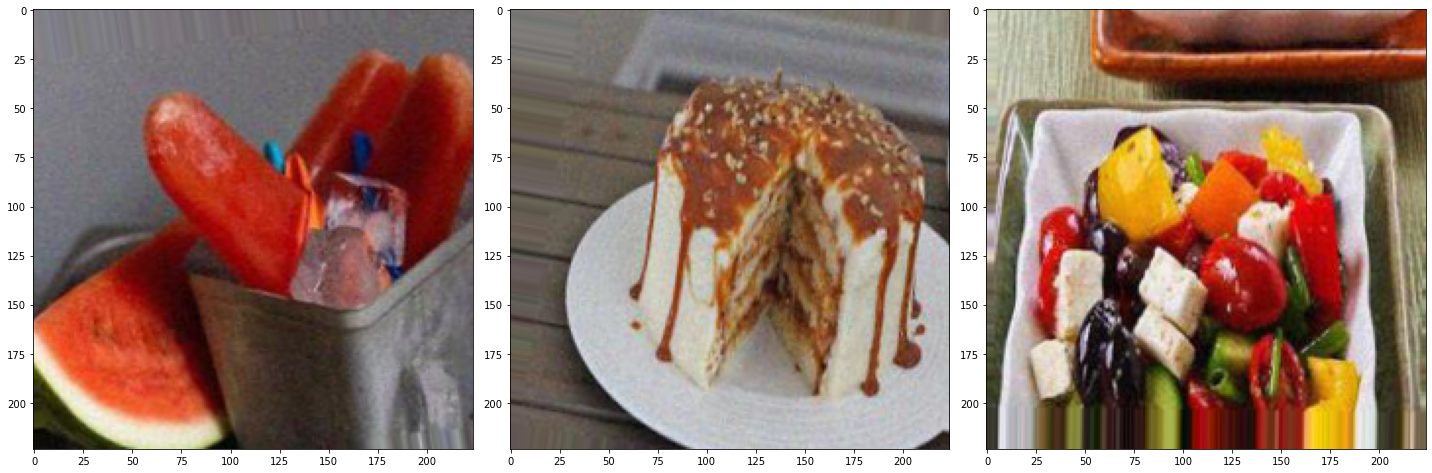

In [29]:
# # This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 3, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# augmented_images = [my_gen[0][0][0] for i in range(3)]
augmented_images = my_gen.__getitem__(0)
augmented_images = np.array(augmented_images)
print(augmented_images.shape)
plotImages(augmented_images[:,0,:,:,:])

In [39]:
#save images to disk
# augmented_images = my_gen.__getitem__(0)
# augmented_images = np.array(augmented_images)
# print(augmented_images.shape)
# print(augmented_images[0,0,:,:,:].shape)

# img = augmented_images[0,0,:,:,:]


# matplotlib.image.imsave('name.png', img)


(3, 1, 224, 224, 3)
(224, 224, 3)


In [8]:
for i in range(0,59520*5):
    j = i % 59520
    augmented_images = np.array(my_gen.__getitem__(j))
    matplotlib.image.imsave('aug_triplets/anchor/class1/' + str(i) + ".jpg", augmented_images[0,0,:,:,:])
    matplotlib.image.imsave('aug_triplets/positive/class1/' + str(i) + ".jpg", augmented_images[1,0,:,:,:])
    matplotlib.image.imsave('aug_triplets/negative/class1/' + str(i) + ".jpg", augmented_images[2,0,:,:,:])

    if i % 100 == 0:
        print(i)
        # break